### Basic imports 

In [3]:
import numpy as np
import tensorflow as tf
import os
import psycopg2
import matplotlib.pyplot as plt
import pandas as pd
print(f'Pandas version: {pd.__version__}, Pandas 2.0+ is faaaaaaastttt 🔥')

Pandas version: 2.0.3, Pandas 2.0+ is faaaaaaastttt 🔥


<h1><center><font size=20 color="greeb"> KillBills case study solution!</font> </h1></center> 
<h1><center> By Juan López </h1></center> 

## <h1><font size=10; color="white"> 1. Let's check the database using DBeaver 🦫</font> </h1>

#### My go-to tool for exploring databases is DBeaver, I will use it to test the connection, write some test queries, and get general information overall of the database without having to use psycopg2

#### After exploring the database I see that there are not other useful tables in the database that can be joined with the "items" table to get more useful information about the records. Therefore we have to deal with the columns that we have: 

    ['id', 'amount', 'description', 'date', 'itemName', 'parent', 'quantity','taxAmount', 'taxDescription', 'type', 'storeId', 'createdAt', 'updatedAt', 'taxRate']


#### ⚜️ As you can see we are dealing with 1.6g of data, which normally would be fine for my PC's memory. However, we have 9 + million rows which is * a lot *. 9 million rows are too much for most machines and is almost over the recomended limit for performing efficient calculations using Pandas. I can tell right away that one of the challenges in this particular case study is how to build machine learning models out if big databases with limiterd resources!



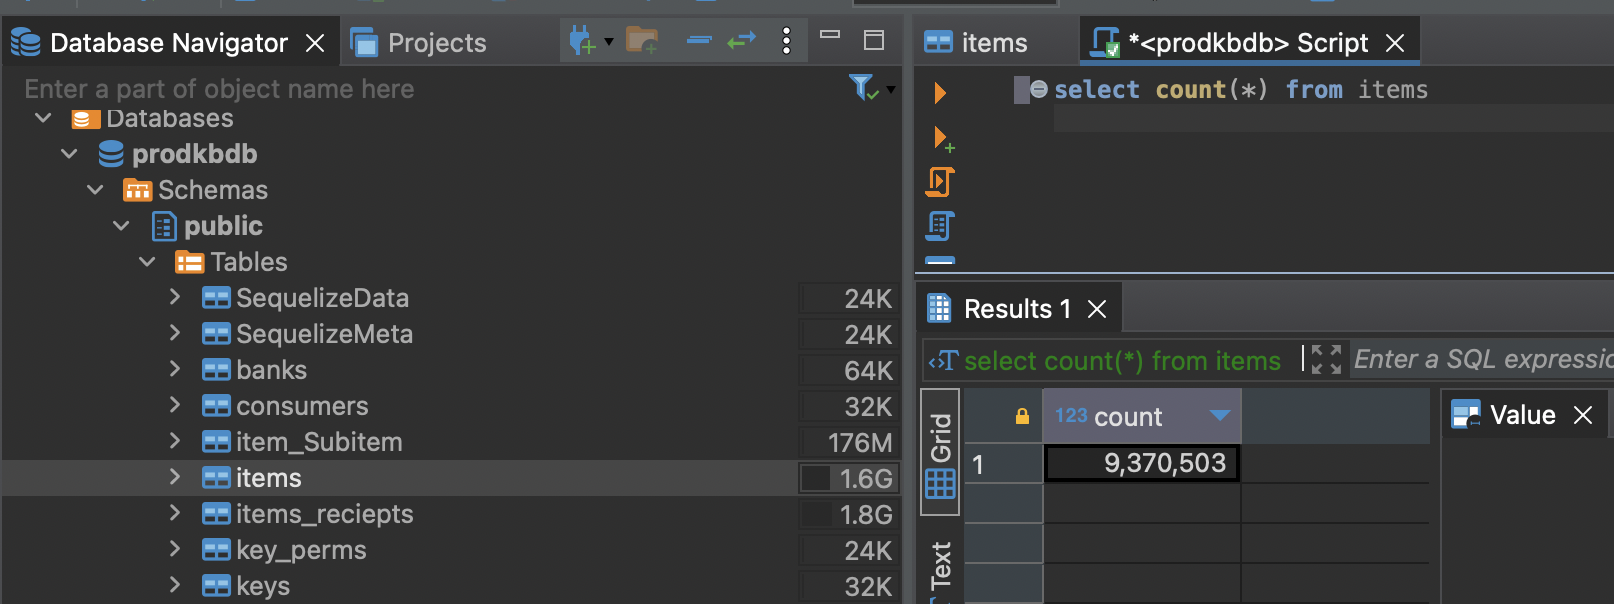
 
#### ⚜️ Since we have a lot of data points, we would like to sample a reduced version of the database if we are going to train any model or perform any kind of data exploration. A straight forward aproach would be performing a query to get random samples in the database, however this is not a good idea since we can expect that the number of data points are not evenly distributed in time. Let's first set up a connection to the database using psycopg2 and explore the database a little bit before exploring a better solution.



### DB settings and some useful functions:

In [4]:
# Get DB settings
def get_db_config():

    DB_NAME = os.environ.get('DB_NAME', "prodkbdb")
    DB_USER = os.environ.get('DB_USER', "testdata")
    DB_PASSWORD = os.environ.get('DB_PASSWORD', "testData678341A")
    DB_HOST = os.environ.get('DB_HOST', "prod-rds-db.cbijryjiwdgw.eu-west-3.rds.amazonaws.com")
    DB_PORT = os.environ.get('DB_PORT', '5432')

    return DB_NAME, DB_USER, DB_PASSWORD, DB_HOST, DB_PORT


# Perform connection to DB
def db_connect():

    # Get database credentials
    DB_NAME, DB_USER, DB_PASSWORD, DB_HOST, DB_PORT = get_db_config()
    # Attempt connection
    try:
        conn = psycopg2.connect(database=DB_NAME, user=DB_USER, password=DB_PASSWORD ,host=DB_HOST, port=DB_PORT)
    except Exception as err:
        print(err)
    return conn

# Function to perform an easy query to the database and return a pandas data frame
def easy_query(query_statement):
    conn = db_connect()
    cur = conn.cursor()
    # Use public schema
    cur.execute("SET search_path TO public")

    # Query
    cur.execute(f"""{query_statement}""") 
    query = cur.fetchall()

    colnames = [desc[0] for desc in cur.description]
    # Close the connection to DB
    conn.close()
    table = pd.DataFrame(query, columns=colnames)

    return table

# This function converts a pandas timestamp into a sring PostgreSQL timestamp
def timestamp_tosql(t):
    
    # return f"""TIMESTAMP('{t.year}-{t.month}-{t.day}','{t.hour}:{t.minute}')"""
    return f"""'{t.year}-{t.month}-{t.day} {t.hour}:{t.minute}'"""


# <h1><font size=10; color="white">2. Selecting a meaningful slice in the dataframe </h1></font>

- Let's see the colums on the "items" table. How are they relevant to do classifications. What colums gives information. (See what colums are not nullable and in what columns we tend to have less nulls.)
- Do we have important keys to make joins so we get extra information?



### <font color="white"> 2.1 Min and Max time stamps </font>
### I will query the timestamps for the first and last record and calculate their difference in seconds. That will let us select a time range suitable to querry the data

In [5]:
# Query the database to get the min and max time stamps
query_1 = """
select min(i."updatedAt"), max(i."updatedAt") from "items" i
"""
df_out = easy_query(query_1)

first_timestamp = df_out["min"][0]
last_timestamp = df_out["max"][0]


del df_out # Get away from my RAM
time_diff = (last_timestamp - first_timestamp)

print(f"Number of days passed between the first and the last record: {time_diff.days}")

Number of days passed between the first and the last record: 92



### ⚜️ We are dealing from a short span of time! the days difference between the first and last record is roughtly 90 days, we want to make sure we are selecting meanigful slices of data for the data analysis and to test and build models out of them if required. However, since KillBills is growing and is adding new costumers everyday (most likely with new categories of products) I would like to se the input of new data over time first and then discuss about the next steps



### <font color="white">2.2 Check the number of records added per day since the first record</font>

In [43]:
# We set the delta of time to be one day
delta =  pd.Timedelta('1 days 00:00:00') 
# Number of intervals (AKA: the number if queries) would be defined by the following division
intervals = int(time_diff.days/delta.days)

N = 100 # Number of records to be querried per interval

x_axis = np.arange(intervals) # Define the x axis for plotting later
y_axis = []

# Connect to db
conn = db_connect()
# Create cursor
cur = conn.cursor()
for i in range(intervals):


    start = timestamp_tosql(first_timestamp+i*delta)
    end = timestamp_tosql(first_timestamp+delta*(i+1))

    # Use public schema
    cur.execute("SET search_path TO public") # Is this necessary?
    # Query
    cur.execute(f"""
                Select count(*) as records_counted from items i 
                where i."updatedAt" BETWEEN  {start} and {end}    
                """) 
    query = cur.fetchall()

    colnames = [desc[0] for desc in cur.description]
    # Close the connection to DB
    
    table = pd.DataFrame(query, columns=colnames)
    y_axis.append(table['records_counted'][0])

conn.close()


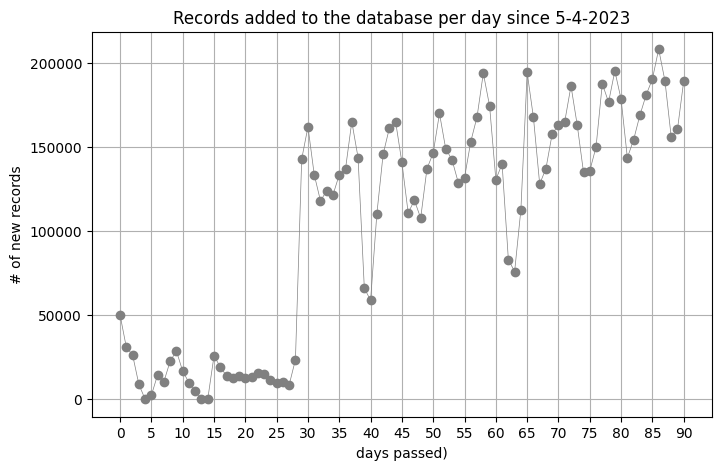

In [47]:
plt.figure(figsize=(8,5))
plt.title(f'Records added to the database per day since {first_timestamp.day}-{first_timestamp.month}-{first_timestamp.year}')
plt.plot(x_axis, np.array(y_axis), color = 'gray', marker = 'o', linewidth = 0.5)
plt.grid()
plt.xlabel("days passed)")
plt.xticks(range(0,intervals, 5))
plt.ylabel("# of new records")
plt.show()



### ⚜️ EXPLORATION: We can see that the number of data points is indeed increasing with time, and we can even see some fluctuations with a defined freacuency! Mostly due because of increased activity in weekends!

### ⚜️ EXPLORATION: It is evident that in around may 5 (day 30 after the start date) something happend regarding to the business beacuse we can see mayor change of the behaviour in the curve. After this day we can see that the behavior is more consistent, therefore we will take the data form may 5 until now


### ⚜️ EXPLORATION: Since the behaviour of the new recrds after may 5 if fairly consistent, I will be safe to query random data points from that time period onwards.

### <font color="white"> 2.3 Getting data! </font>

### I have decided to simply get N random datapoints from 05/05/2023 onwards, this is a simple but the correct approach!

In [123]:

# Number of racords to rectrieve from the database
N = 10000

# Query random records from may 5 onwards
df = easy_query(f"""
                    select * from items 
                    where items."updatedAt" BETWEEN  {timestamp_tosql(pd.Timestamp(day=5, month=5, year=2023, tz='UTC'))} and {timestamp_tosql(last_timestamp)}
                    ORDER BY RANDOM() 
                    limit {N}
                """)


df.head(5)

,id,amount,description,date,itemName,parent,quantity,taxAmount,taxDescription,type,storeId,createdAt,updatedAt,taxRate
0,557f25ec-f130-4956-be6d-c8c5836f2d27,1.40,,None,arenas - marbré x-6,None,None,0.08,TVA 5.5 %,,0db7bcc2-1f04-434d-8ae5-cb4ee7c9d0a0,2023-06-23 10:06:57.070000+00:00,2023-06-23 10:06:57.070000+00:00,550
1,1c3f44ba-bb16-4bbe-bedb-c8072d584382,5.88,None,None,crispy saumon,None,None,0.53,TVA 10 %,None,5000ce16-8a90-4135-9f39-0df035959ff2,2023-07-03 18:22:35.117000+00:00,2023-07-03 18:22:35.117000+00:00,1000
2,c23098d4-1573-4304-9402-52b375c6cfdd,6.24,None,None,california saumon avocat,None,None,0.33,TVA 5.5 %,None,f76fc5f9-8955-4168-b7dc-3aa92269830e,2023-06-12 19:09:55.281000+00:00,2023-06-12 19:09:55.281000+00:00,550
3,28f954d0-292d-49ca-a76d-8ae0a18f4437,2.50,,None,lot 2 tradition,None,None,0.14,TVA 5.5 %,,e8c01ac2-c866-4cf4-ad5b-3f54a4946a8d,2023-05-09 11:32:11.473000+00:00,2023-05-09 11:32:11.473000+00:00,550
4,598daa95-1325-4cbd-a10c-7a9a54f2d132,2.96,,None,riz thai jasmin,None,None,0.16,TVA 5.5 %,,23e9fb7e-1d15-4d40-bf3c-dff6c42c6d73,2023-06-18 12:15:11.239000+00:00,2023-06-18 12:15:11.239000+00:00,550


# <h1><font size=10; color="white">3. Exploring the data in detail </font></h1>

Let's check some important information about the dataset on the columns that might be useful

In [119]:
# Value counts for each column
for col in ['description', 'itemName', 'taxDescription', 'taxRate']:
    print(f' 🔹 Value counts for column "{col}"')
    print(df[col].value_counts()[:6])
    print('----------------------------------------------------------------')


 🔹 Value counts for column "description"
description
                     5262
product               225
message generique      56
.                      24
menu                   14
cafe                   13
Name: count, dtype: int64
----------------------------------------------------------------
 🔹 Value counts for column "itemName"
itemName
frites                      142
baguette                     67
sauce sucrée offerte         62
california saumon avocat     61
expresso                     54
cafe                         50
Name: count, dtype: int64
----------------------------------------------------------------
 🔹 Value counts for column "taxDescription"
taxDescription
TVA 10 %            5465
TVA 5.5 %           2360
TVA 20 %             808
TVA 0 %              489
TVA 2.1 %            377
noTaxDescription     341
Name: count, dtype: int64
----------------------------------------------------------------
 🔹 Value counts for column "taxRate"
taxRate
1000    5465
550     2360

In [122]:
# Description for each column
for col in ['description', 'itemName', 'taxDescription', 'taxRate']:
    print(f' 🔸 Description for column "{col}"')
    print(df[col].describe())
    print('----------------------------------------------------------------')

 🔸 Description for column "description"
count     6086
unique     407
top           
freq      5262
Name: description, dtype: object
----------------------------------------------------------------
 🔸 Description for column "itemName"
count      10000
unique      4795
top       frites
freq         142
Name: itemName, dtype: object
----------------------------------------------------------------
 🔸 Description for column "taxDescription"
count        10000
unique          16
top       TVA 10 %
freq          5465
Name: taxDescription, dtype: object
----------------------------------------------------------------
 🔸 Description for column "taxRate"
count    10000.000000
mean       858.407500
std        468.849356
min          0.000000
25%        550.000000
50%       1000.000000
75%       1000.000000
max       2100.000000
Name: taxRate, dtype: float64
----------------------------------------------------------------


### ⚜️ As you can see it is pretty clear that the colum that gives the most information is "itemName". However, the taxDescription gives us the legal comsumption tax for that specific item, which give us information about the category of the item since according to the french law certain items have to be taxed diferent.

# <h1><font size=10; color="gold"> 5. Defining the approach: Using HuggingFace 🤗 Transformers </font></h1>

### We have landed into the following situation:

    1. We don't know which categories should be use to classify the data such that it will be useful for killBills...
    2. The only useful column is the "itemName" column, which contains strings with the name of the product.
    3. The "taxDescription" column gives us information about how should we classify the items according to the french law*


### This is a tought situation, but thankfylly NLP models are strong enough to deal with this situation! Let's take discuss more about this:

### 1. Why NLP? We basically don't have more information other that the semantic information in the 'itemName' column, it means that we have to tackle this problem with a pretrained NLP model

### 2. What kind of NLP task are we going to use? In this aproach we are going to define the class candidates and then try pretrained models to perform  "zero-shot classification" task, which basically means that even though the set was trained with different labels, it will be able to classify new examples from previously unseen classes. More on how this models works later on.

### 3. Why hugging face? HuggingFace is becoming one of the leading communities/platforms to share, build and use Deep Learning models. Theirs Transformers APIs provide an easy way to implement ready-to-use pre-trained models for a variety of tasks. These models also support fine-tuning!








<h1><font size=10; color="gold"> What did I do? </font></h1>



### My approach consisted in using the Pipeline API to quickly use the models according to our needs. This API provides a huge level of abstraction that tokenizes our inputs, runs the inference of the model and then processes the outputs.

### As discussed before, I am going to use models for Zero-Shot classification, the models used for this are actually used to classify a premise and a hypothesis in three different classes (entailment, contradiction, and neutral). For zero-shot classification we are proposing different hypotesis into a premise and returning the hypotesis with the highest score in the "entailment" class. You can see more about this on the following link: 
    https://huggingface.co/tasks/zero-shot-classification



### Keep in mind that this models are fine-tunable! If new classes are defined according to a certain business requirement we can label our own dataset and fine-tune the models on it. We can do this using the HuggingFace Trainer API.

### I tried various multi-lingual (because we are dealing with french) models in Huggins face zero-shot repo and I ended up finding that the bigger the models the better. I discovered that if I added extra description to the premises and to the hypotesis the model work better! I used the following custom premises and hypothesis:


    - Premise: "dans le menu, il y a {itemName}"
    - Hypotesis: "l'élément du menu est {labels}"

### This way I ended up having way more success for the classification than using the recommended premises and hypothesis from HuggingFace Transformers guide.



## Defining labels for classification

### As discussed previously, we are free to define the categories that we want. For this case study I selected some simple categories, but I am conviced that if we fine tune model w might use it to predict more specific classes.

### In the next function we are going to assign a set of possible categories according to the TaxDescription. We are going to use the fact that for a TVA of 20% the product most likely contains alcohol.

In [249]:
# Install transformers
#! pip install transformers


# Define a class to asign categories possibilities according to the TVA description of the item
def assign_categories(taxDescription):

    categories = {
    'TVA 10 %'  : ['drink', 'food', 'dessert', 'sweet', 'pastries'],
    'TVA 5.5 %' : ['drink', 'food', 'dessert', 'sweet', 'pastries'],
    'TVA 20 %'  : ['drink', 'food', 'dessert', 'sweet', 'pastries', 'alcoholic drink'],
    'TVA 0 %'   : ['drink', 'food', 'dessert', 'sweet', 'pastries'],
    'TVA 2.1 %' : ['drink', 'food', 'dessert', 'sweet', 'pastries'],
    'other'     : ['drink', 'food', 'dessert', 'sweet', 'pastries', 'alcoholic drink'],
    }
    
    if taxDescription in categories.keys():
        candidate_labels = categories[taxDescription]

    else:
        candidate_labels = categories['other']
    
    return candidate_labels

# Function to clear emojis from a string
    

# Model used "MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7"
### After trying some models, this is the one that performed the best. You can find more information here:
   - https://huggingface.co/MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7?candidateLabels=alcoholic+drink%2C+drink%2C+dessert&multiClass=true&text=%22fuze+tea%22

In [252]:
from transformers import pipeline
model_name = 'MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7'
classifier = pipeline("zero-shot-classification", model=model_name)


<h1><font size=10; color="gold"> Submission </font></h1>

1. The function "DataFrameInference" takes an "item", aka a row of the database as a pandas data frame and returns the predicted category
2. The model cannot be sent through email since it is to heavy! The best way to have it ready is just to auto download it while running the script

In [253]:

def DataFrameInference(dataframe):

    '''
    Performs an Inference given a pandas dataframe with rowstaken from the "items"
    Input: Pandas dataframe

    Output: Pandas dataframe containg the itemNames and predicted categories

    '''
    # TODO: INSTEAD OF ITERATING OVER ROWS USE PD.APPY()


    df_out = pd.DataFrame()
    names = []
    statement = []
    categories = []

    print(f'Now using model {model_name}')
    for _, row in dataframe.iterrows():


        predicate = "dans le menu, il y a "
        itemName = row['itemName']
        taxDescription = row['taxDescription']


        

        candidate_labels = assign_categories(taxDescription)
        


        sequence_to_classify = predicate+itemName
        hypothesis_template = "l'élément du menu est {}"

        # classify using the information provided
        out = classifier(sequence_to_classify, candidate_labels, hypothesis_template=hypothesis_template)

        names.append(itemName)
        statement.append(out['sequence'])
        categories.append(out['labels'][0])

    df_out['names'] = names
    df_out['statement'] = statement
    df_out['categories'] = categories

    return df_out





# Testing the model!

In [244]:
data = df.sample(30)
df_out = DataFrameInference(data)
df_out.sample(30)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Now using model morit/french_xlm_xnli


,names,statement,categories
1,menu néo bento sashimi 12 pièces,"dans le menu, il y a menu néo bento sashimi 12...",food
7,onion rings,"dans le menu, il y a onion rings",food
10,simple fromager,"dans le menu, il y a simple fromager",food
12,pita falafel,"dans le menu, il y a pita falafel",food
14,5fromages 33,"dans le menu, il y a 5fromages 33",food
18,quinoa aux algues,"dans le menu, il y a quinoa aux algues",food
21,pulled pork,"dans le menu, il y a pulled pork",food
6,coca,"dans le menu, il y a coca",drink
20,formule mezzé,"dans le menu, il y a formule mezzé",food
22,avocado salmon,"dans le menu, il y a avocado salmon",food
